# Statistical Analysis of Tennis Data - An investigation into the expected tournament winnings of a professional tennis player
### Using data from the top 1500 players, spanning from 2009 to 2017

In [1]:
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import math

In [2]:
# load and investigate the data here:

stats = pd.read_csv('tennis_stats.csv')
# stats.info()
print(stats.head())


                 Player  Year  FirstServe  FirstServePointsWon  \
0           Pedro Sousa  2016        0.88                 0.50   
1       Roman Safiullin  2017        0.84                 0.62   
2           Pedro Sousa  2017        0.83                 0.60   
3   Rogerio Dutra Silva  2010        0.83                 0.64   
4  Daniel Gimeno-Traver  2017        0.81                 0.54   

   FirstServeReturnPointsWon  SecondServePointsWon  \
0                       0.38                  0.50   
1                       0.26                  0.33   
2                       0.28                  0.53   
3                       0.34                  0.59   
4                       0.00                  0.33   

   SecondServeReturnPointsWon  Aces  BreakPointsConverted  BreakPointsFaced  \
0                        0.39     0                  0.14                 7   
1                        0.07     7                  0.00                 7   
2                        0.44     2      

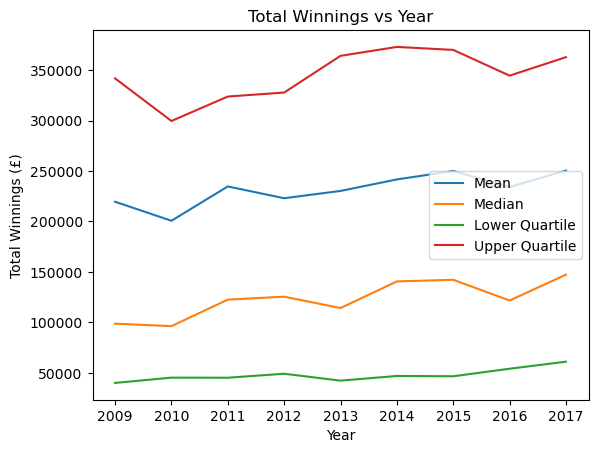

In [3]:
# Lets explore how average winnings have changed with time

mean_winnings_vs_year = stats.groupby('Year').Winnings.mean()
median_winnings_vs_year = stats.groupby('Year').Winnings.median()
up_quart_winnings_vs_year = []
low_quart_winnings_vs_year = []
quarts_winnings_vs_year = []

for year in stats.Year.unique():
    up_quart = np.percentile(stats[stats.Year == year].Winnings,75)
    low_quart = np.percentile(stats[stats.Year == year].Winnings,25)

    quarts_winnings_vs_year.append([low_quart,up_quart])

# print(mean_winnings_vs_year)

quarts_winnings_vs_year = pd.DataFrame(quarts_winnings_vs_year)
quarts_winnings_vs_year.index = stats.Year.unique()
quarts_winnings_vs_year.sort_index(axis=0,inplace=True)
quarts_winnings_vs_year.rename(columns={0:'low_quart', 1:'up_quart'}, inplace=True)
# print(quarts_winnings_vs_year)

plt.title('Total Winnings vs Year')
plt.plot(mean_winnings_vs_year, label='Mean')
plt.plot(median_winnings_vs_year, label='Median')
plt.plot(quarts_winnings_vs_year.low_quart, label='Lower Quartile')
plt.plot(quarts_winnings_vs_year.up_quart, label = 'Upper Quartile')
plt.xlabel('Year')
plt.ylabel('Total Winnings (£)')
plt.legend()
plt.show()


# We can see that in general, winnings for a tennis player in the top 1500 is rising from year to year. The mean is
## significantly higher than the median, indicating a heavily right-skewed dataset where the top earners earn a
### disproportionally large amount of money compared to the rest of the top 1500 - this is somewhat expected
#### intuitively, however the median may be a more useful statistic in this instance for looking at the average
##### winnings for a tennis player. It is evident that the fluctuation in the winnings for the top-earners is a key
###### factor in the uncertainty of the rise in winnings from year to year, as the upper quartile oscillates in a very
####### similar fashion to the median and mean, whereas the lower quartile shows a more consistent, steady increase.


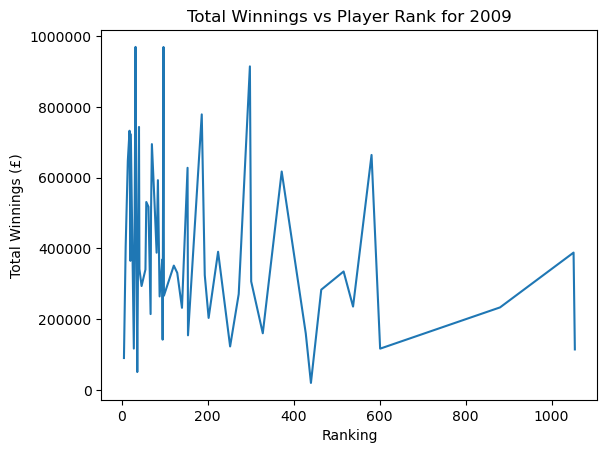

In [13]:
# I wanted to see how winnings varied with ranking for each year, but it is clear that this is heavily linked to the
## number of matches played, which is seemingly random looking at the data here (in reality this will be due to
### factors such as injuries which are not captured in this dataset). I will look at this in more detail next.

RvW_2009 = stats[stats.Year == 2009][['Ranking','Winnings','Wins', 'Losses']]
RvW_2009['Matches_played'] = RvW_2009.apply(lambda row: row.Wins + row.Losses, axis = 1)
RvW_2009 = RvW_2009[RvW_2009.Matches_played >= 10]
RvW_2009.sort_values(by='Ranking', inplace=True)
RvW_2009.reset_index(inplace=True, drop=True)

x_2009 = RvW_2009.Ranking
y_2009 = RvW_2009.Winnings

plt.close()
plt.title('Total Winnings vs Player Rank for 2009')
plt.xlabel('Ranking')
plt.ylabel('Total Winnings (£)')
plt.ticklabel_format(style='plain', axis='y')
plt.plot(x_2009,y_2009)
plt.show()

R-squared value: 0.8536490928943863
Money per Match Win: 16179.767160127703
Money per Match Loss: 8414.611614785883


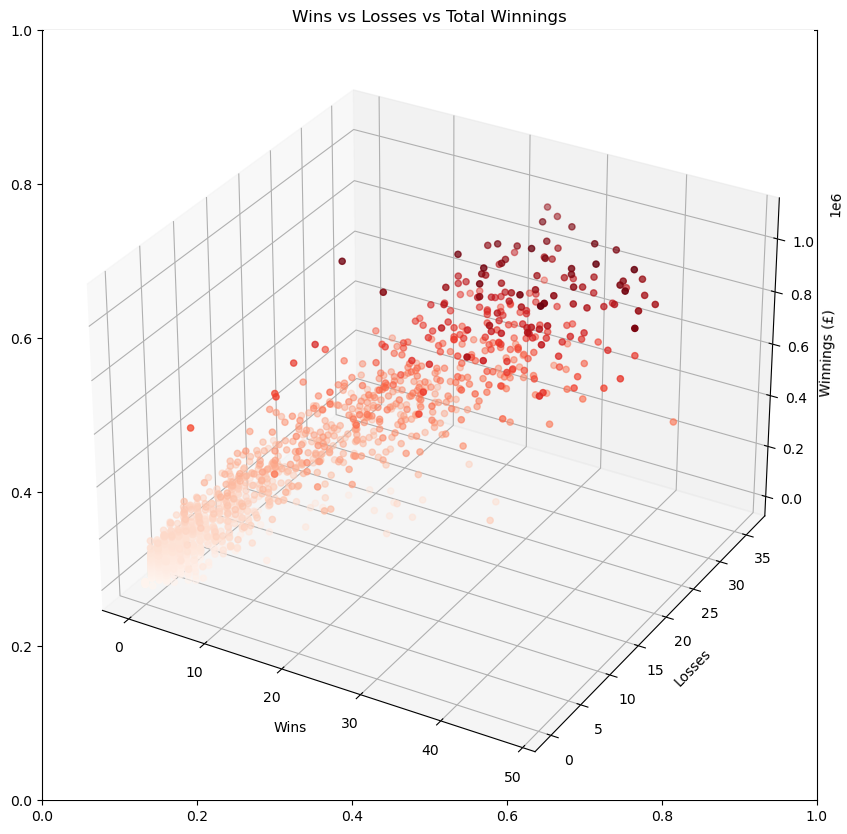

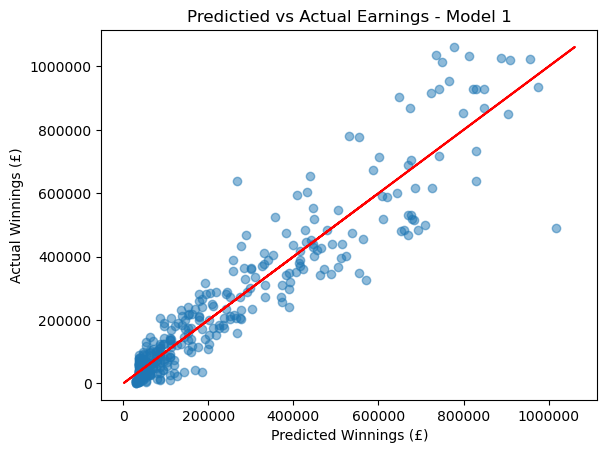

In [25]:
# Lets see how the number of wins and losses affect winnings

win_loss_vs_winnings = stats[['Wins','Losses','Winnings']]
x1 = win_loss_vs_winnings[['Wins', 'Losses']]
y1 = win_loss_vs_winnings['Winnings']

plt.close()
plt.figure(figsize=(10,10))
plt.title('Wins vs Losses vs Total Winnings')
ax = plt.axes(projection='3d')
zdata = y1
xdata = x1.Wins
ydata = x1.Losses
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds')
ax.set_xlabel('Wins')
ax.set_ylabel('Losses')
ax.set_zlabel('Winnings (£)')

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=5)

fit_winnings = LinearRegression()

fit_winnings.fit(x_train1, y_train1)

y_predicted1 = fit_winnings.predict(x_test1)

print('R-squared value: ' + str(fit_winnings.score(x1,y1)))

money_per_win = fit_winnings.coef_[0]
money_per_loss = fit_winnings.coef_[1]

print('Money per Match Win: '+ str(money_per_win))
print('Money per Match Loss: '+ str(money_per_loss))

plt.figure()
plt.scatter(y_predicted1,y_test1,alpha=0.5)
plt.title('Predictied vs Actual Earnings - Model 1')
plt.plot(y_test1, y_test1,'r')
plt.xlabel('Predicted Winnings (£)')
plt.ylabel('Actual Winnings (£)')
plt.ticklabel_format(style='plain', axis='both')
plt.show()

# An R-squared value of over 85% is very significant, meaning the relationship of wins and losses to winnings is very
## strong (as expected). Factors such as tournament, viewing figures etc. may also factor into this but are not 
### captured in this dataset - I will now explore how other factors may affect this

R-squared value: 0.8788604188096907
Win coefficient: 16963.465465773763
Loss coefficient: 7233.143279276817
Year coefficient: 13757.191842125198
Rank coefficient: -74.84950314985969


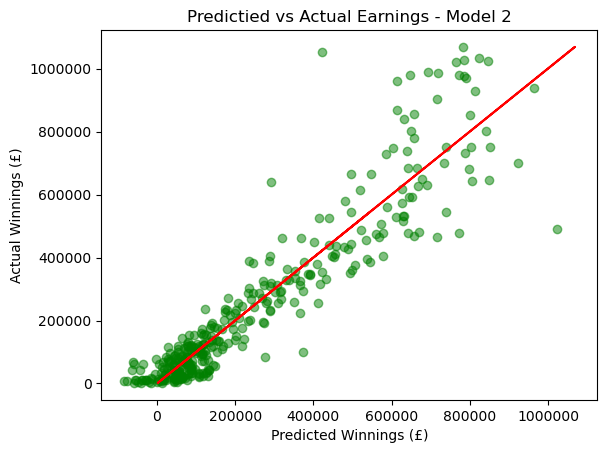

In [27]:
# Lets investigate how wins, losses, year and ranking affect winnings

multi_factor_vs_winnings = stats[['Wins','Losses','Year','Ranking','Winnings']]

x2 = multi_factor_vs_winnings[['Wins','Losses','Year','Ranking']]
y2 = multi_factor_vs_winnings['Winnings']

multi_fit_winnings = LinearRegression()

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, train_size=0.8, test_size=0.2, random_state=6)

multi_fit_winnings.fit(x_train2, y_train2)

y_predicted2 = multi_fit_winnings.predict(x_test2)

print('R-squared value: ' + str(multi_fit_winnings.score(x2,y2)))
print('Win coefficient: ' + str(multi_fit_winnings.coef_[0]))
print('Loss coefficient: ' + str(multi_fit_winnings.coef_[1]))
print('Year coefficient: ' + str(multi_fit_winnings.coef_[2]))
print('Rank coefficient: ' + str(multi_fit_winnings.coef_[3]))

plt.close()
plt.figure()
plt.scatter(y_predicted2,y_test2,alpha=0.5,color='Green')
plt.plot(y_test2,y_test2,'r')
plt.title('Predictied vs Actual Earnings - Model 2')
plt.ticklabel_format(style='plain', axis='both')
plt.xlabel('Predicted Winnings (£)')
plt.ylabel('Actual Winnings (£)')
plt.show()


# An even better model with an R squared value of 87.88% - The coefficients seem to add up: Win and Loss values are
## similar to before, the year coefficient shows a general increase in winnings year on year, and the rank has a
### negative coefficient i.e. as rank gets smaller (closer to 1), the winnings get larger - I imagine this is because
#### the bigger names draw bigger crowds/viewing figures etc. but that is outside the scope of this analysis

In [7]:
# Now I've got a good model I'll use it to predict my potential earning if I decided to become a professional tennis
## player. Let's say on Jan 1st 2018 I started training 8 hours a day, 365 days a year, assuming it takes 10,000 hours
### of practice to achieve professional level and become the 1500 seed (ignoring the thousands of unseeded players).
#### In my first year lets say I enter all the grand slams (4) and lose my first match in each one:

start_year = math.ceil(2018 + (10000/(8*365)))
seed = 1500
wins = 0
losses = 4

test = [wins, losses, start_year, seed]

print(sum(multi_fit_winnings.coef_*test) + multi_fit_winnings.intercept_)

# Not a bad starting salary!
## NOTE: I do not accept any responsibility for the pursuit of as tennis career following the read of this analysis

84973.11530984566
